In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np
import pickle
import matplotlib.pyplot as plt
from src.dataloaders import MHDataLoader
from src.models import SimpleEncoder, SimpleDecoder, ConvEncoder, ConvDecoder
from src.utils.reverse_pianoroll import piano_roll_to_pretty_midi as pr2pm

In [2]:
MIDI_LOW = 48
MIDI_HIGH = 84
DATASET_SIZE = 1000
BATCH_SIZE = 20

dataset = pickle.load(open('../data/mh-midi-data.pickle', 'rb'))
######## divide into train, validation, and test ########
# based on the mean and standard deviation of non zero entries in the data, I've
# found that the most populous, and thus best range of notes to take is from
# 48 to 84 (C2 - C5); this is 3 octaves
dataset = dataset[:DATASET_SIZE, :, MIDI_LOW:MIDI_HIGH, :]

train = dataset[:int(DATASET_SIZE*0.8)]
train_dataloader = MHDataLoader(train)
batched_train = train_dataloader.get_batched_data(BATCH_SIZE)

valid = dataset[int(DATASET_SIZE*0.8):int(DATASET_SIZE*0.9)]
valid_dataloader = MHDataLoader(valid)
batched_valid = valid_dataloader.get_batched_data(BATCH_SIZE)

test = dataset[int(DATASET_SIZE*0.9):]
test_dataloader = MHDataLoader(test)
batched_test = test_dataloader.get_batched_data(BATCH_SIZE)
##############################

In [3]:
input_size = train[0].shape
# enc_input_dim = np.prod(input_size)
# dec_input_dim = enc_input_dim/8
# encoder = SimpleEncoder(enc_input_dim)
# decoder = SimpleDecoder(dec_input_dim, apply_sigmoid=True)
enc_channels = [8, 16]
dec_channels = enc_channels[::-1]
encoder = ConvEncoder(input_size, enc_channels)
decoder = ConvDecoder(encoder.output_dim, dec_channels, input_size, apply_sigmoid=True)

param_dict = torch.load('runs/simple_mse_1000n_700ep_e-4lr/model_state.pt')
encoder.load_state_dict(param_dict['encoder'])
print encoder.output_dim
decoder.load_state_dict(param_dict['decoder'])

192


In [6]:
encoded_train = encoder(Variable(torch.FloatTensor(dataset))).data.numpy()
mean = np.mean(encoded_train, axis=0)
cov = np.cov(encoded_train, rowvar=False)

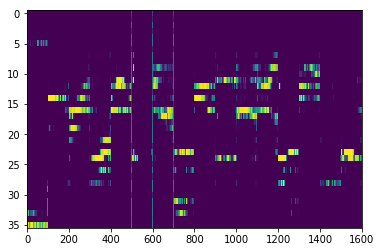

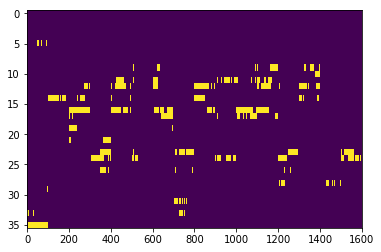

In [7]:
samples = np.random.multivariate_normal(mean, cov, 16)
decoded_samples = decoder(Variable(torch.FloatTensor(samples)))
decoded_song = decoded_samples.view(train[:16].shape).data.numpy()
decoded_song_array = np.concatenate(decoded_song[:, 0, :, :], axis=1)

plt.imshow(decoded_song_array, aspect="auto")
plt.show()

normalized_dsa = np.round(decoded_song_array/np.max(decoded_song_array))
plt.imshow(normalized_dsa, aspect="auto")
plt.show()

midi_array = np.zeros((128, 100*16))
midi_array[MIDI_LOW:MIDI_HIGH] = np.round(decoded_song_array)
outmidi = pr2pm(midi_array.round())
outmidi.write('generated_midi.mid')